<a href="https://colab.research.google.com/github/biniyam-mulugeta/final/blob/main/Decition_Tree_kf_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np 
import keras
from keras.models import Model
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,DepthwiseConv2D,Add#,Dense,Dropout,Conv2D
from keras.applications import densenet,mobilenet, mobilenet_v2,efficientnet#densenetmobilenet_v2#,efficientnet,vgg16,densenet
from keras.applications import vgg19,resnet
#from keras_preprocessing import image
#from keras_preprocessing.image import ImageDataGenerator
#from keras.utils.all_utils import to_categorical
from sklearn import preprocessing
from skimage.filters import threshold_otsu
import cv2
from pathlib import Path
import os
import glob
import matplotlib.pyplot as plt
#import seaborn as sns
#import zipfile
%matplotlib inline

In [3]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score,GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import classification_report,f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from skimage import io

In [4]:
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,Input,Dense,Dropout,Conv2D,Activation,MaxPooling2D,BatchNormalization
from keras.layers import MaxPool2D,AveragePooling2D

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [6]:
SIZE = 32
data_image = []
data_label = []
for dir_path in glob.glob("/content/drive/My Drive/coffee_dataset/*"):
    label = dir_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        print(img_path)
        img = cv2.imread(img_path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(SIZE,SIZE))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        
        img = cv2.GaussianBlur(img,(5,5),0)
  
        #img = otsu_segmentation(img)]

        data_image.append(img)
        data_label.append(label)
data_image = np.array(data_image)
data_label = np.array(data_label)

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/coffee_dataset/phoma_cro/456_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_2.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_3.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_4.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_5.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_6.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_7.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_8.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_2.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_3.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_4.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/460.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/461.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/461_1.jpg
/content/dr

In [7]:
le = preprocessing.LabelEncoder()
le.fit(data_label)
train_labe_encoded = le.transform(data_label)

In [8]:
x_train,y_train = data_image,train_labe_encoded
x_train = x_train/255.0

### train test split

In [9]:
x_tr,x_te,y_tr,y_te = train_test_split(x_train,train_labe_encoded,test_size=0.20,shuffle=True,random_state=42,stratify=train_labe_encoded)

In [10]:
print(x_tr.shape,'----',y_tr.shape)
print(x_te.shape,'----',y_te.shape)

(5653, 32, 32, 3) ---- (5653,)
(1414, 32, 32, 3) ---- (1414,)


In [ ]:
#x_v,x_tes,y_v,y_tes = train_test_split(x_te,y_te,test_size=0.5,shuffle=True,random_state=42,stratify=y_te)

### GoogleNet

In [11]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [12]:
kernel_init = keras.initializers.he_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [13]:
input_layer = Input(shape=(32, 32, 3))

x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((2, 2), padding='same', strides=(1, 1), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(2, 2), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((2, 2), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')


x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(7, activation='softmax', name='output')(x)
google_net = Model(input_layer,x, name='inception_v1')

### ResNet

In [14]:
from keras.layers import add
stride = 1
CHANNEL_AXIS = 3

def res_layer(x ,filters,pooling = False,dropout = 0.0):
    temp = x
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)
    temp = BatchNormalization(axis = CHANNEL_AXIS)(temp)
    temp = Activation("relu")(temp)
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)

    x = add([temp,Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(x)])
    if pooling:
        x = MaxPooling2D((2,2))(x)
    if dropout != 0.0:
        x = Dropout(dropout)(x)
    x = BatchNormalization(axis = CHANNEL_AXIS)(x)
    x = Activation("relu")(x)
    return x

In [15]:
inp = Input(shape = (32,32,3))
x = inp
x = Conv2D(16,(3,3),strides = stride,padding = "same")(x)
x = BatchNormalization(axis = CHANNEL_AXIS)(x)
x = Activation("relu")(x)
x = res_layer(x,32,dropout = 0.2)
x = res_layer(x,64,dropout = 0.3)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.23)(x)
x = Dense(7,activation = "softmax")(x)

resnet_model = Model(inp,x,name = "Resnet")

### proposed model

In [16]:
out1 = google_net.get_layer(index = -3).output
out2 = resnet_model.get_layer(index= -3).output
out = concatenate([out1,out2])
"""
out = Dense(64,activation='relu')(out)
out = Dropout(0.40)(out)
out = Dense(128,activation='relu')(out)
out = Dropout(0.45)(out)
out = Dense(256,activation='relu')(out)
#out = Dropout(0.50)(out)


output = Dense(8,activation='softmax')(out)"""

"\nout = Dense(64,activation='relu')(out)\nout = Dropout(0.40)(out)\nout = Dense(128,activation='relu')(out)\nout = Dropout(0.45)(out)\nout = Dense(256,activation='relu')(out)\n#out = Dropout(0.50)(out)\n\n\noutput = Dense(8,activation='softmax')(out)"

In [17]:
e_model = Model(inputs = [google_net.input,resnet_model.input],outputs = out)

In [18]:
print("Feature extraction ...Training")
prediction_tr = np.array(e_model.predict([x_tr,x_tr]))
prediction_tr.shape

Feature extraction ...Training


(5653, 480)

In [19]:
Xtrain = np.reshape(prediction_tr, (prediction_tr.shape[0], prediction_tr.shape[1]))

In [20]:
#print("Feature extraction ...validation")
#prediction_v = np.array(e_model.predict([x_te,x_te]))

#prediction_v.shape

Feature extraction ...validation


(1414, 480)

In [ ]:
#Xvalidate = np.reshape(prediction_v, (prediction_v.shape[0], prediction_v.shape[1]))

In [21]:
print("Feature extraction ...Testing")
prediction_tes = np.array(e_model.predict([x_te,x_te]))

Feature extraction ...Testing


In [22]:
Xtest = np.reshape(prediction_tes, (prediction_tes.shape[0], prediction_tes.shape[1]))

In [23]:
print('\tFeatures training shape: ', Xtrain.shape)
#print('\tFeatures testing shape: ', Xvalidate.shape)
print('\tFeatures testing shape: ', Xtest.shape)

	Features training shape:  (5653, 480)
	Features testing shape:  (1414, 480)


#### Decition Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [26]:
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2,4,6,8]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(Xtrain, y_tr)

Fitting 3 folds for each of 392 candidates, totalling 1176 fits


In [27]:
print(grid_search_cv.best_params_,grid_search_cv.best_score_)

{'max_leaf_nodes': 95, 'min_samples_split': 6} 0.8462743640428684


In [28]:
df = pd.DataFrame(grid_search_cv.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_leaf_nodes,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.348488,0.004224,0.001471,0.000023,2,2,"{'max_leaf_nodes': 2, 'min_samples_split': 2}",0.288594,0.289278,0.289278,0.289050,0.000322,389
1,0.344768,0.008645,0.001449,0.000036,2,4,"{'max_leaf_nodes': 2, 'min_samples_split': 4}",0.288594,0.289278,0.289278,0.289050,0.000322,389
2,0.338921,0.004451,0.001479,0.000051,2,6,"{'max_leaf_nodes': 2, 'min_samples_split': 6}",0.288594,0.289278,0.289278,0.289050,0.000322,389
3,0.339348,0.002746,0.001454,0.000022,2,8,"{'max_leaf_nodes': 2, 'min_samples_split': 8}",0.288594,0.289278,0.289278,0.289050,0.000322,389
4,0.499384,0.003577,0.001528,0.000029,3,2,"{'max_leaf_nodes': 3, 'min_samples_split': 2}",0.414324,0.414544,0.414544,0.414470,0.000104,385
...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,1.322084,0.046001,0.001729,0.000037,98,8,"{'max_leaf_nodes': 98, 'min_samples_split': 8}",0.856233,0.831210,0.846072,0.844505,0.010276,57
388,1.564603,0.241663,0.001847,0.000287,99,2,"{'max_leaf_nodes': 99, 'min_samples_split': 2}",0.854111,0.829087,0.849788,0.844329,0.010921,63
389,1.300396,0.040100,0.001680,0.000032,99,4,"{'max_leaf_nodes': 99, 'min_samples_split': 4}",0.854111,0.829087,0.847665,0.843621,0.010609,106
390,1.293287,0.024481,0.001665,0.000024,99,6,"{'max_leaf_nodes': 99, 'min_samples_split': 6}",0.857294,0.832272,0.849257,0.846274,0.010431,1


In [29]:
df = pd.DataFrame(grid_search_cv.cv_results_)
mask = df['rank_test_score']<10
newdf = df[mask]
newdf[['param_max_leaf_nodes','param_min_samples_split','params','mean_test_score','rank_test_score']]

,param_max_leaf_nodes,param_min_samples_split,params,mean_test_score,rank_test_score
314,80,6,"{'max_leaf_nodes': 80, 'min_samples_split': 6}",0.845391,9
322,82,6,"{'max_leaf_nodes': 82, 'min_samples_split': 6}",0.845567,6
366,93,6,"{'max_leaf_nodes': 93, 'min_samples_split': 6}",0.845567,8
370,94,6,"{'max_leaf_nodes': 94, 'min_samples_split': 6}",0.846098,3
374,95,6,"{'max_leaf_nodes': 95, 'min_samples_split': 6}",0.846274,1
378,96,6,"{'max_leaf_nodes': 96, 'min_samples_split': 6}",0.846098,3
382,97,6,"{'max_leaf_nodes': 97, 'min_samples_split': 6}",0.845567,7
386,98,6,"{'max_leaf_nodes': 98, 'min_samples_split': 6}",0.845921,5
390,99,6,"{'max_leaf_nodes': 99, 'min_samples_split': 6}",0.846274,1


In [30]:
dt=DecisionTreeClassifier(max_leaf_nodes=95,min_samples_split=6)

In [ ]:
print('training values for DT')
dt.fit(Xtrain, y_tr)

training values for DT


DecisionTreeClassifier(max_leaf_nodes=87)

	Training Accuracy of DT: 0.8392


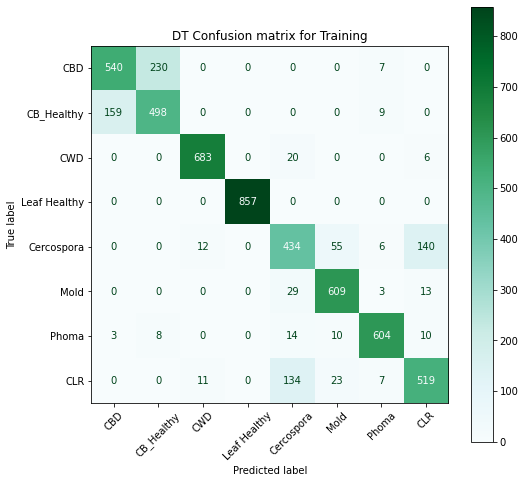

In [ ]:
    predict_train = dt.predict(Xtrain)
    fig,ax = plt.subplots(figsize=(8,8))
    acc = accuracy_score(predict_train, np.ravel(y_tr, order='C'))
    print("\tTraining Accuracy of DT: %0.4f" % acc)
    cm = confusion_matrix(y_tr, predict_train, labels=dt.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("DT Confusion matrix for Training")
    plt.show()

predicting values for DT
	Validation Accuracy of DT: 0.7878


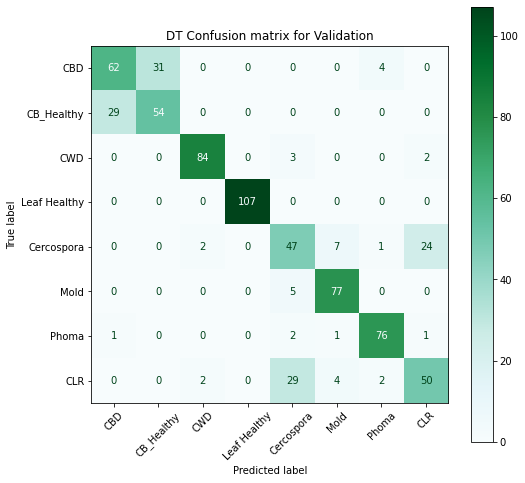

In [ ]:
    print('predicting values for DT')
    predict_validate = dt.predict(Xvalidate)
    fig,ax = plt.subplots(figsize=(8,8))
    acc = accuracy_score(predict_validate, np.ravel(y_v, order='C'))
    print("\tValidation Accuracy of DT: %0.4f" % acc)
    cm = confusion_matrix(y_v, predict_validate, labels=dt.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("DT Confusion matrix for Validation")
    plt.show()

predicting values for  DT
	Testing Accuracy of DT: 0.7977


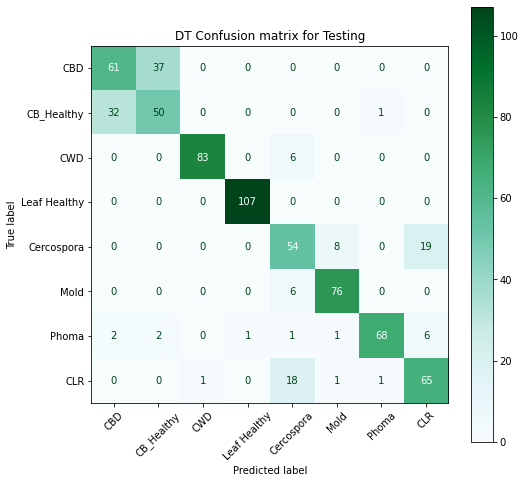

In [ ]:
    print('predicting values for  DT')
    predict_test = dt.predict(Xtest)
    fig,ax = plt.subplots(figsize=(8,8))
    acc = accuracy_score(predict_test, np.ravel(y_tes, order='C'))
    print("\tTesting Accuracy of DT: %0.4f" % acc)
    cm = confusion_matrix(y_tes, predict_test, labels=dt.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("DT Confusion matrix for Testing")
    plt.show()

In [ ]:
print(classification_report(y_tes,predict_test,target_names=target_names))

              precision    recall  f1-score   support

         CBD       0.64      0.62      0.63        98
  CB_Healthy       0.56      0.60      0.58        83
         CWD       0.99      0.93      0.96        89
     Healthy       0.99      1.00      1.00       107
  Cercospora       0.64      0.67      0.65        81
        Mold       0.88      0.93      0.90        82
       Phoma       0.97      0.84      0.90        81
         CLR       0.72      0.76      0.74        86

    accuracy                           0.80       707
   macro avg       0.80      0.79      0.80       707
weighted avg       0.80      0.80      0.80       707



In [ ]:
from yellowbrick.classifier import ROCAUC,ConfusionMatrix
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0:'cbd',1: 'cb_healthy',2: 'CWD',3: 'leaf healthy' ,4: 'Cercospora', 5: 'mold', 6: 'phoma',7 : 'rust'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

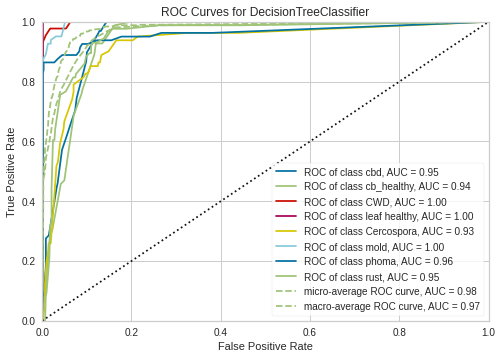

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d9b6a0490>,
       encoder={0: 'cbd', 1: 'cb_healthy', 2: 'CWD', 3: 'leaf healthy',
                4: 'Cercospora', 5: 'mold', 6: 'phoma', 7: 'rust'},
       estimator=DecisionTreeClassifier(max_leaf_nodes=87))

In [ ]:
plot_ROC_curve(dt,Xtrain,y_tr,Xtest,y_tes)

### using k fold

In [24]:
#skfolds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)
skfolds = KFold(n_splits=3)

In [31]:
dt=DecisionTreeClassifier(max_leaf_nodes=95,min_samples_split=6)
score = []
i = 0
for trainset,testset in skfolds.split(Xtrain,y_tr):
    predicted_targets = np.array([])
    actual_targets = np.array([])
    accuracy_list = list()
    predicted_train_targets = np.array([])
    actual_train_targets = np.array([])
    accuracy_train_list = list()
    print("folds ", i)
    print(trainset,"having :" , len(trainset))
    print(testset,"having :" , len(testset))

    x_tr,x_te=Xtrain[trainset],Xtrain[testset]
    y_trin,y_test=y_tr[trainset],y_tr[testset]

    #clone_clf = clone(svm)
    dt.fit(x_tr, y_trin)
    predicted_labels = dt.predict(x_te)
    accuracy = accuracy_score(y_test, predicted_labels)
    
    predicted_t_labels = dt.predict(x_tr)
    accuracy_t = accuracy_score(y_trin, predicted_t_labels)
    
    predicted_targets = np.append(predicted_targets, predicted_labels)
    actual_targets = np.append(actual_targets, y_test)
    accuracy_list.append(accuracy)
    
    predicted_train_targets = np.append(predicted_train_targets, predicted_t_labels)
    actual_train_targets = np.append(actual_train_targets, y_trin)
    accuracy_train_list.append(accuracy_t)
    
    print("iteration", i)
    i+=1

folds  0
[1885 1886 1887 ... 5650 5651 5652] having : 3768
[   0    1    2 ... 1882 1883 1884] having : 1885
iteration 0
folds  1
[   0    1    2 ... 5650 5651 5652] having : 3769
[1885 1886 1887 ... 3766 3767 3768] having : 1884
iteration 1
folds  2
[   0    1    2 ... 3766 3767 3768] having : 3769
[3769 3770 3771 ... 5650 5651 5652] having : 1884
iteration 2


In [32]:
labeles = ['CBD','CB_Healthy','CWD','Leaf Healthy','Cercospora','Mold','Phoma','CLR']
target_names = ['CBD','CB_Healthy','CWD','Healthy','Cercospora','Mold','Phoma','CLR']

	Training Accuracy of DT: 0.9544


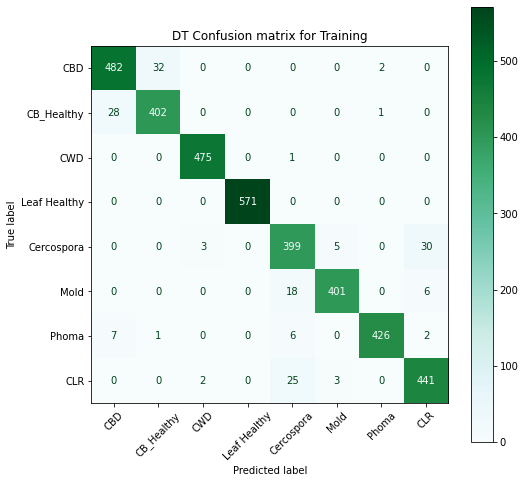

In [33]:
    fig,ax = plt.subplots(figsize=(8,8))
    acc = accuracy_score(predicted_t_labels, np.ravel(y_trin, order='C'))
    print("\tTraining Accuracy of DT: %0.4f" % acc)
    cm = confusion_matrix(actual_train_targets, predicted_train_targets, labels=dt.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("DT Confusion matrix for Training")
    plt.show()

	Validation Accuracy of DT: 0.8535


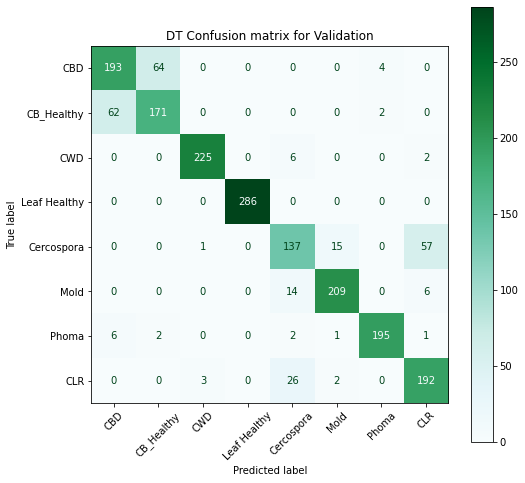

In [34]:
    fig,ax = plt.subplots(figsize=(8,8))
    acc = accuracy_score(predicted_labels, np.ravel(y_test, order='C'))
    print("\tValidation Accuracy of DT: %0.4f" % acc)
    cm = confusion_matrix(actual_targets, predicted_targets, labels=dt.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("DT Confusion matrix for Validation")
    plt.show()

In [35]:
result = dt.predict(Xtest)

print(classification_report(y_te,result,target_names=target_names))

	Testing Accuracy of DT: 0.8529
              precision    recall  f1-score   support

         CBD       0.78      0.76      0.77       195
  CB_Healthy       0.73      0.75      0.74       166
         CWD       0.96      0.98      0.97       178
     Healthy       1.00      1.00      1.00       214
  Cercospora       0.71      0.64      0.67       162
        Mold       0.90      0.93      0.91       164
       Phoma       0.97      0.96      0.96       162
         CLR       0.73      0.77      0.75       173

    accuracy                           0.85      1414
   macro avg       0.85      0.85      0.85      1414
weighted avg       0.85      0.85      0.85      1414



	Testing Accuracy of DT: 0.8529


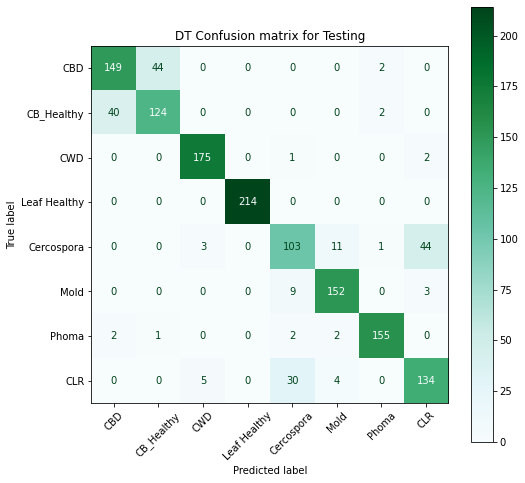

In [38]:
    acc = accuracy_score(result, np.ravel(y_te, order='C'))
    print("\tTesting Accuracy of DT: %0.4f" % acc)
    fig,ax = plt.subplots(figsize=(8,8))
    cm = confusion_matrix(y_te, result, labels=dt.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("DT Confusion matrix for Testing")
    plt.show()

In [40]:
from yellowbrick.classifier import ROCAUC,ConfusionMatrix
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0:'cbd',1: 'cb_healthy',2: 'CWD',3: 'leaf healthy' ,4: 'Cercospora', 5: 'mold', 6: 'phoma',7 : 'rust'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

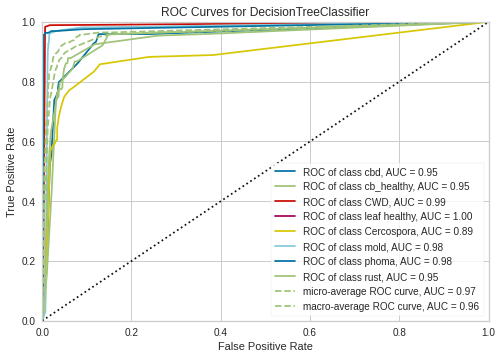

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd5ed8bf50>,
       encoder={0: 'cbd', 1: 'cb_healthy', 2: 'CWD', 3: 'leaf healthy',
                4: 'Cercospora', 5: 'mold', 6: 'phoma', 7: 'rust'},
       estimator=DecisionTreeClassifier(max_leaf_nodes=95, min_samples_split=6))

In [41]:
plot_ROC_curve(dt,Xtrain,y_tr,Xtest,y_te)

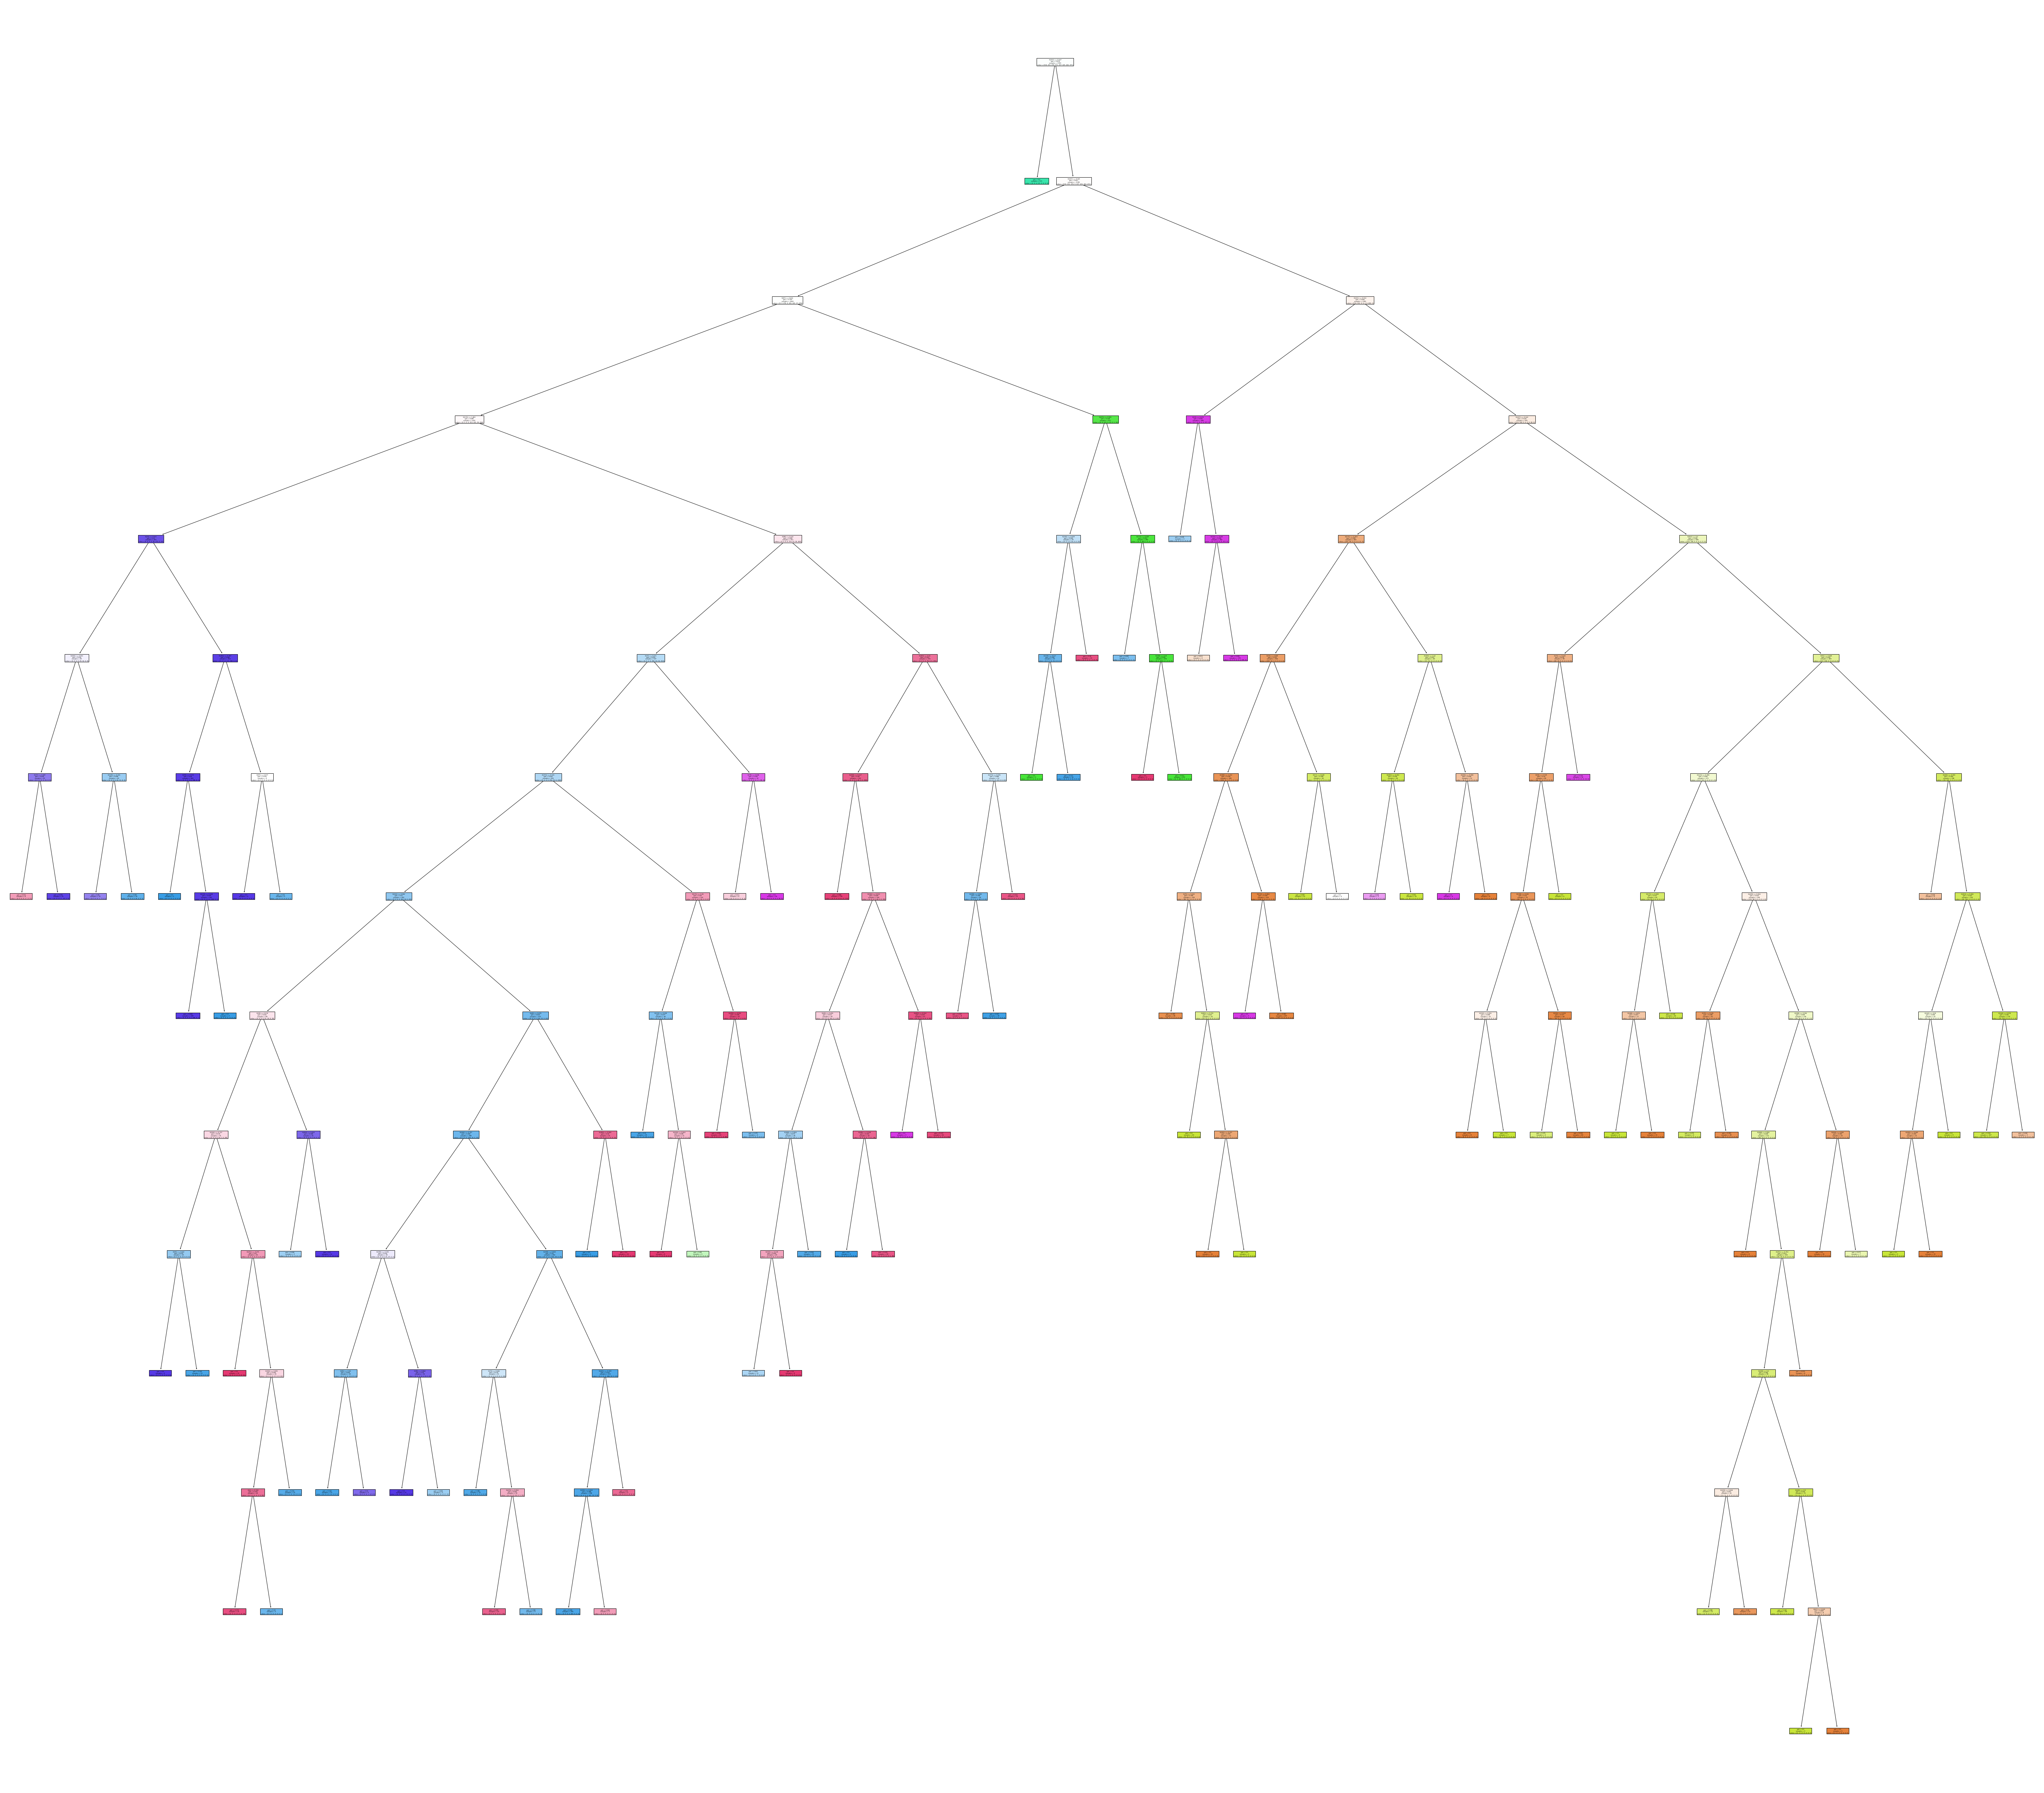

In [39]:
from sklearn import tree
fig = plt.figure(figsize=(100,90))
_ = tree.plot_tree(dt,filled=True)